<h1><b>Assignment #3 - Naive Bayes</b></h1>
Ryan Harris
<p><i>October 2020</i>

<h2><b>Prepare Data for Analysis</b></h2>

<h4><b><u>Load Dependencies</u></b></h4>

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pylab as plt
import math
import sklearn.metrics as metrics

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from dmba import classificationSummary

<h4><b><u>Set Definitions</u></b></h4>

In [2]:
def rounddown(num, dvsr):
    return num - (num%dvsr)

<h4><b><u>Import and transform data</u></b></h4>

In [3]:
#Import Data
flights_df = pd.read_csv('FlightDelays.csv')

#Transform Date to Day Name Category
flights_df['DAY_WEEK'] = pd.to_datetime(flights_df['FL_DATE']).dt.day_name()

#Bucketing departure times in to categoreis by intervals of 300 as CRS_DEP_TIME_CAT
flights_df['CRS_DEP_TIME_CAT'] = pd.cut(flights_df['CRS_DEP_TIME'], [500, 900, 1200, 1500, 1800, 2100, 2400], labels=['Early Morning', 'Morning', 'Early Afternoon', 'Afternoon', 'Early Evening','Evening'])

#Check data
flights_df.head()


,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status,CRS_DEP_TIME_CAT
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,Thursday,1,N940CA,ontime,Early Afternoon
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,Thursday,1,N405FJ,ontime,Afternoon
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,Thursday,1,N695BR,ontime,Early Afternoon
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,Thursday,1,N662BR,ontime,Afternoon
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,Thursday,1,N698BR,ontime,Morning


<h4><b><u>Split Into Training and Validation</u></b></h4>

In [4]:
#Identify predictors and outcome
predictors = ['CRS_DEP_TIME_CAT','CARRIER','DEST','DISTANCE','ORIGIN','Weather','DAY_WEEK','DAY_OF_MONTH','TAIL_NUM']
outcome = ['Flight Status']

#Establish X and y
X = pd.get_dummies(flights_df[predictors])
y = (flights_df[outcome] == 'ontime').astype(int)
classes = ['ontime', 'delayed']

#Split into Training and Validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = .4, random_state = 6011)

#Check counts
print("y_train "+y_train.size.astype(str),"y_valid "+ y_valid.size.astype(str))

y_train 1320 y_valid 881


<h2><b>Perform Analysis</b></h2>

<h3><b><u>Naive Bayes</u></b></h3>

In [5]:
flights_nb = MultinomialNB(alpha=0.01)
flights_nb.fit(X_train, y_train)

C:\Users\harri\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MultinomialNB(alpha=0.01)

<u><b><h3>Predict Probabilities and Membership</u></b></h3>

In [6]:
#predict probabilities
predProb_train = flights_nb.predict_proba(X_train)
predProb_valid = flights_nb.predict_proba(X_valid)


#predict class membership
y_train_pred = flights_nb.predict(X_train)
y_valid_pred = flights_nb.predict(X_valid)

<h2><b>Results</b></h2>

<u><b><h3>Counts and Proportion Table by Airport</u></b></h3>

In [7]:
#trim DF to just Airport and flight status
flights_df_trim = flights_df[['DEST','Flight Status','TAIL_NUM']].copy()
flights_df_trim.columns = ['DEST','Flight_Status','TAIL_NUM'] 

#Counts Table
table = flights_df_trim.groupby(['DEST','Flight_Status']).count()
print(table)
#Percentages Tableu
table_pcts = table.groupby(level=0).apply(lambda x:
                                         100 * x / float(x.sum()))
print(table_pcts)

                    TAIL_NUM
DEST Flight_Status          
EWR  delayed             161
     ontime              504
JFK  delayed              84
     ontime              302
LGA  delayed             183
     ontime              967
                     TAIL_NUM
DEST Flight_Status           
EWR  delayed        24.210526
     ontime         75.789474
JFK  delayed        21.761658
     ontime         78.238342
LGA  delayed        15.913043
     ontime         84.086957


<u><b><h3>Confusion Matrix and ROC for Validation Data</u></b></h3>

Confusion Matrix (Accuracy 0.7185)

        Prediction
 Actual  ontime delayed
 ontime      62     123
delayed     125     571


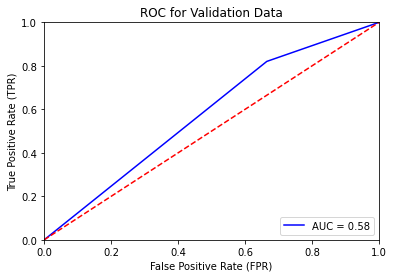

In [8]:
#Confusion matrix
classificationSummary(y_valid, y_valid_pred, class_names=classes)

#Establish False Positive Rate (fpr) and True Positive Rate (tpr)
preds = predProb_valid[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_valid, y_valid_pred)
roc_auc = metrics.auc(fpr, tpr)

#plot ROC
plt.title('ROC for Validation Data')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.show()